<a href="https://colab.research.google.com/github/DhrubaAdhikary/ERA_V2/blob/master/S13/ERA1_S11_converted_S13_CIFAR10_Pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Models & Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/DhrubaAdhikary/ERA_V2.git -q --quiet
!mv ERA_V2/pytorch-era2-main/* .
!rm -rf ERA_V2/pytorch-era2-main
print("Loaded Modules and Models")

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet
!pip install torch-lr-finder -q --quiet
!pip install grad-cam

# For inline matplotlib plotting
%matplotlib inline

Loaded Modules and Models
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38071 sha256=a60ec4b184e67b291b9f0dea2c9a50e389cd169cc8395b48fedc8a46731167a5
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


# Loading train and test data with transforms and loader functions

In [3]:
# !pip install pytorch-lightning-bolts
!pip install lightning-bolts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 1.2 MB/s eta 0:00:00


In [4]:
from utils import *

/usr/local/lib/python3.10/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The featu

In [5]:
from utils import *
from pl_bolts.datamodules import CIFAR10DataModule

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=album_Compose_train(),
    test_transforms=album_Compose_test(),
    val_transforms=album_Compose_test(),
)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/coarse_dropout.py:115: DeprecationWarning: Use num_holes_range instead.
  self.num_holes_range = update_range(self.min_holes, self.max_holes, self.num_holes_range)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/coarse_dropout.py:116: DeprecationWarning: Use hole_height_range instead.
  self.hole_height_range = update_range(self.min_height, self.max_height, self.hole_height_range)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/coarse_dropout.py:117: DeprecationWarning: Use hole_width_range instead.
  self.hole_width_range = update_range(self.min_width, self.max_width, self.hole_width_range)


In [6]:
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from models.custom_resnet import *

model = LitCustomResnet(lr=0.01, batch_size = BATCH_SIZE)

trainer = Trainer(
    max_epochs=24,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 170498071/170498071 [00:05<00:00, 33738218.32it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | Net  | 4.1 M 
-------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.260    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9023000001907349     │
│         test_loss         │    0.28555506467819214    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.28555506467819214, 'test_acc': 0.9023000001907349}]

,lr-Adam,training loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.000163,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.578209,NaN,NaN,NaN,NaN
0.0,NaN,NaN,1.468027,0.4846,NaN,NaN
NaN,0.000294,NaN,NaN,NaN,NaN,NaN
1.0,NaN,1.366737,NaN,NaN,NaN,NaN


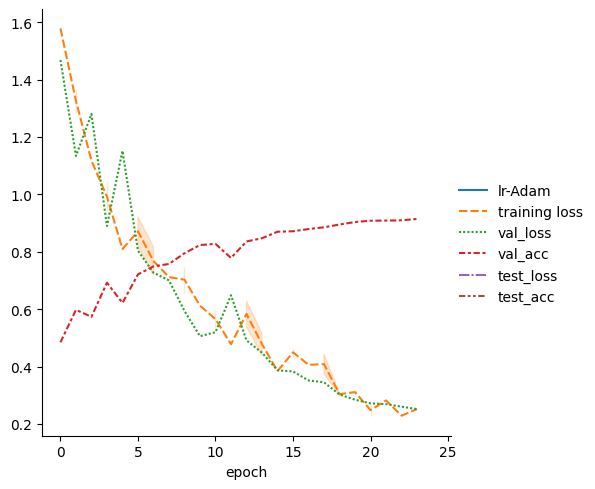

In [7]:
import pandas as pd
import seaborn as sn

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

## Misclassified Images - GradCAM

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


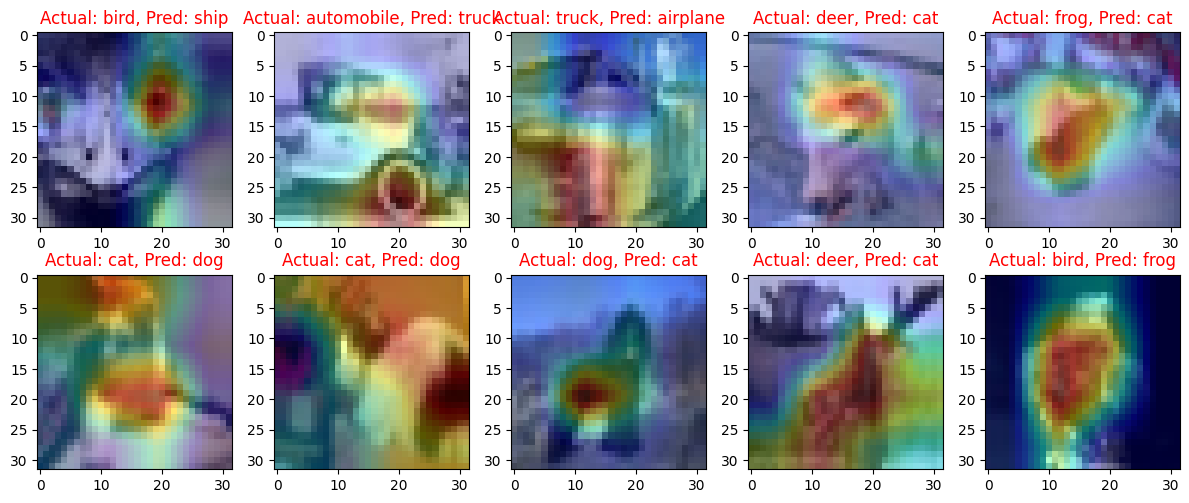

In [8]:
import torch
plot_grad_cam_images_custom_resnet(model.model, cifar10_dm.test_dataloader(), cifar10_dm.dataset_train.dataset.classes, device=torch.device("cpu"))

## Saving Models

In [9]:
torch.save(model.model.state_dict(), "custom_resnet_model.pt")

## Saving Misclassified images

In [10]:
!mkdir misclassfied_images

In [11]:
from PIL import Image
import numpy as np

test_loader = cifar10_dm.test_dataloader()
classes =  cifar10_dm.dataset_train.dataset.classes
device = torch.device("cuda")
model1 = model.model.to(device)

# set model to evaluation mode
model1.eval()

misclassified_images = []

fig_idx = 1
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model1(data)
        _, pred = torch.max(output, 1)
        for i in range(len(pred)):
            if pred[i] != target[i]:
                misclassified_images.append(data[i])
                npimg = unnormalize(data[i].cpu())
                im = Image.fromarray((npimg*255).astype(np.uint8))
                im.save(f"./misclassfied_images/Target_{classes[target[i]]}_Pred_{classes[pred[i]]}_{fig_idx}.jpeg")
                if fig_idx > 25:
                    break
                fig_idx+=1



In [12]:
import shutil

shutil.make_archive("./misclassfied_images", 'zip', "./misclassfied_images")

'/content/misclassfied_images.zip'